In [23]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
from numba import njit
import oommfc as oc
from montecarlo.System import Grid, MCDrive

/Users/gmn22/miniconda3/envs/irp/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/gmn22/miniconda3/envs/irp/lib/python3.8/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


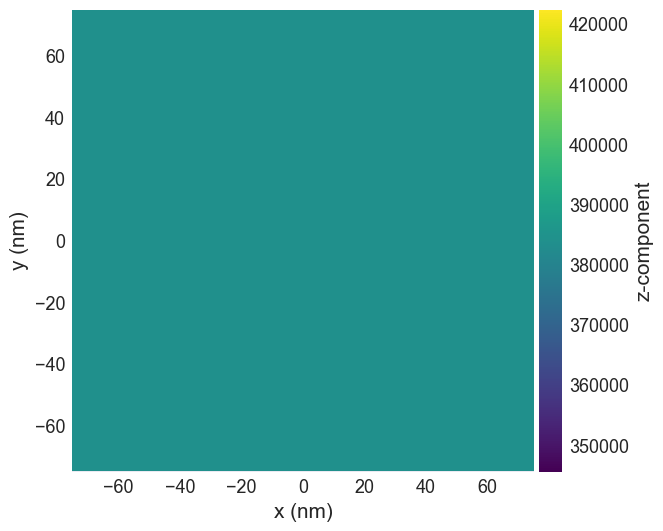

In [24]:
Ms = 3.84e5
A = 8.78e-12

d = 150e-9
hb = 20e-9
ht = 10e-9

cell = (5e-9, 5e-9, 2.5e-9)

subregions = {'r1': df.Region(p1=(-d/2, -d/2, -hb), p2=(d/2, d/2, 0)), 'r2': df.Region(p1=(-d/2, -d/2, 0), p2=(d/2, d/2, ht))}

p1 = (-d/2, -d/2, -hb)
p2 = (d/2, d/2, ht)

mesh = df.Mesh(p1=p1, p2=p2, cell=cell, subregions=subregions)

def Ms_fun(point):
    x, y, z = point
    if x**2 + y**2 < (d/2)**2:
        return Ms
    else:
        return 0

system = mm.System(name='bloch_point')

D_bloch = {'r1': -1.58e-3, 'r2': 1.58e-3, "r1:r2": 1.58e-9}

system.energy = mm.Exchange(A=A) + mm.DMI(D=D_bloch, crystalclass='T')
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)

system.m.plane('z').mpl()

In [4]:
uc = oc.MinDriver()
uc.drive(system)

Running OOMMF (ExeOOMMFRunner)[2023/08/15 18:16]... (2.5 s)


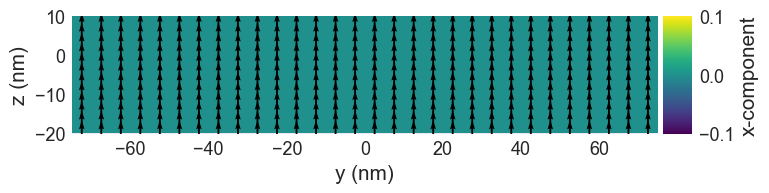

In [25]:
system.m.plane('x').mpl()

In [26]:
regions = {'r1': (-hb, 0), 'r1:r2':  (0, 0), 'r2': (0, ht)}

In [27]:
print(system.m.mesh.subregions)

{'r1': Region(p1=(-7.5e-08, -7.5e-08, -2e-08), p2=(7.5e-08, 7.5e-08, 0)), 'r2': Region(p1=(-7.5e-08, -7.5e-08, 0), p2=(7.5e-08, 7.5e-08, 1e-08))}


In [28]:
print(system.m.norm.value[0, 0, 0])

[384000.]


In [29]:
data = Grid(system=system, Ms=Ms, regions=regions)

In [30]:
print(data.dmi_D.shape, data.grid.shape)

(32, 32, 14) (30, 30, 12, 3)


In [31]:
print(data.dmi_D[3,3, 7], data.dmi_D[3,3,8], data.dmi_D[3,3,9])

-0.00158 -0.00158 0.00158


In [32]:
print(Ms)
print(data.zeeman_K)
print(data.anisotropic_K)
print(data.anisotropic_u)
print(data.exchange_A)
print(data.dmi_D.shape)
print(data.Dtype)
print(data.dx, data.dy, data.dz)
print(data.grid[15, 15, 6])

384000.0
None
None
None
8.78e-12
(32, 32, 14)
T
5e-09 5e-09 2.5e-09
[0. 0. 1.]


In [33]:
print(data.zeeman_energy())
print(data.anisotropic_energy())
print(data.exchange_energy())
print(data.dmi_energy())

0
0
-0.0
0.0


In [34]:
dmi1 = data.dmi_energy()
ub_dmi1 = oc.compute(system.energy.dmi.energy, system)

Running OOMMF (ExeOOMMFRunner)[2023/08/15 18:18]... (1.1 s)


In [35]:
data.dmi_D[3,3,8]

-0.00158

In [36]:
spin = data.grid[3, 3, 9] + np.random.uniform(-0.1, 0.1, 3)

spin = spin/np.linalg.norm(spin)
data.grid[3, 3, 9] = spin

In [37]:
dmi2 = data.dmi_energy()

In [38]:
system.m.array[3,3,9] = spin*Ms
ub_dmi2 = oc.compute(system.energy.dmi.energy, system)

Running OOMMF (ExeOOMMFRunner)[2023/08/15 18:18]... (1.0 s)


In [39]:
print(dmi2 - dmi1)
print(ub_dmi2 - ub_dmi1)

0.0
2.13162820728e-38


In [40]:
mc = MCDrive(data, energy_calc=5, schedule_name='blochness')

In [41]:
mc.field

array([0., 0., 0.])

Step: 0, Temperature: 0.01K, Field: 0.0


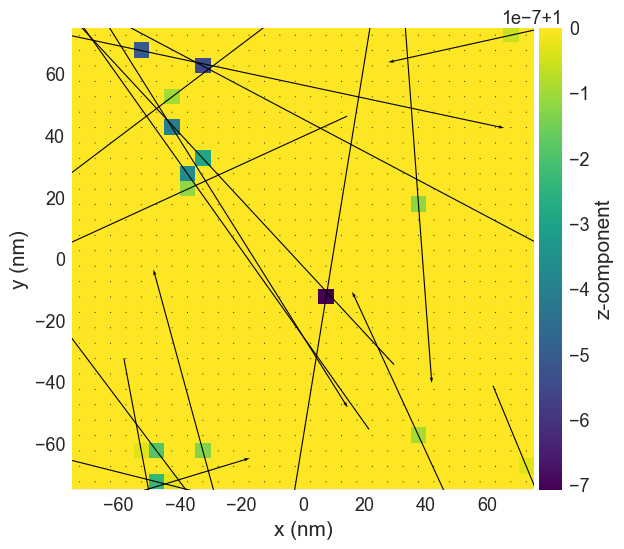

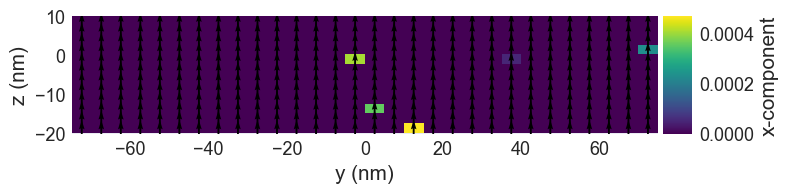

In [42]:
mc.drive(N=5000000, save=True, plot_x=True, plot_z=True)